In [63]:
from skimage.io import imread, imshow, concatenate_images
from math import sqrt

from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage import color
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from skimage.exposure import equalize_adapthist
import skimage
import tensorflow as tf


import os
import random
import pandas as pd
from itertools import chain
from tqdm import tqdm_notebook, tnrange
from tqdm import notebook
import numpy as np
# h5py to read the data-set
import h5py
# matplotlob for plotting
import matplotlib.pyplot as plt
# tensorboard
from keras.callbacks import TensorBoard

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose,UpSampling2D, Conv3D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras

In [49]:
path_training = "D:/AlexanderErnst/DeepLearning_ISV/Data/"

listImages=os.listdir(path_training+"/Images")

In [50]:
def data_collect(path_train,final_size,rgb=False,rotate=False):
    
        
    listImages=os.listdir(path_train+"/Images")
    print(listImages)
    
    n_samples=len(listImages)
    X = np.zeros((n_samples*3, final_size, final_size), dtype=np.float32)
    y = np.zeros((n_samples*3, final_size, final_size), dtype=np.float32)
    
    count=0
    for i in listImages:
        img=imread(path_train+"Images/"+i)
        
        
        
        
        image_downscaled=skimage.transform.resize(img, (final_size, final_size),anti_aliasing=False).astype(np.float32)
        image_downscaled_gaussian=skimage.filters.gaussian(img).astype(np.float32)
        image_downscaled_unsharpmask=skimage.filters.unsharp_mask(img).astype(np.float32)
        listMask=os.listdir(path_train+"/Annotations")
        msk=imread(path_train+"Annotations/"+i)
        
        mask_downscaled=skimage.transform.resize(msk, (final_size, final_size),anti_aliasing=False).astype(np.float32)
        
        print(image_downscaled.shape)
        print(mask_downscaled.shape)
        X[count,:,:]=image_downscaled
        y[count,:,:]=mask_downscaled

        count+=1
        X[count,:,:]=image_downscaled_gaussian
        y[count,:,:]=mask_downscaled
        
        count+=1
        X[count,:,:]=image_downscaled_unsharpmask
        y[count,:,:]=mask_downscaled
        
        count+=1
        print(count)
    return X,y
        
    

In [10]:
?skimage.filters.gaussian

In [52]:
train_data,train_labels=data_collect(path_training,2048)

['MAX_201203155726_20201203_drug_screen_B02_B11_4x_A002.tif', 'MAX_201203155726_20201203_drug_screen_B02_B11_4x_B001.tif', 'MAX_201203155726_20201203_drug_screen_B02_B11_4x_B008.tif', 'MAX_201203155726_20201203_drug_screen_B02_B11_4x_B009.tif', 'MAX_201203155726_20201203_drug_screen_B02_B11_4x_B011.tif', 'MAX_201203155726_20201203_drug_screen_B02_B11_4x_C001.tif', 'MAX_201203155726_20201203_drug_screen_B02_B11_4x_C006.tif', 'MAX_201203155726_20201203_drug_screen_B02_B11_4x_D012.tif', 'MAX_201203155726_20201203_drug_screen_B02_B11_4x_E002.tif', 'MAX_201203155726_20201203_drug_screen_B02_B11_4x_F008.tif', 'MAX_201203155726_20201203_drug_screen_B02_B11_4x_G004.tif', 'MAX_201203155726_20201203_drug_screen_B02_B11_4x_G005.tif', 'MAX_201203155726_20201203_drug_screen_B02_B11_4x_H001.tif', 'MAX_201203155726_20201203_drug_screen_B02_B11_4x_H010.tif', 'MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A001.tif', 'MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_

In [ ]:
# Set some parameters
im_width = 1024
im_height = 1024
stack_size = 34
stack_offset = 0
border = 5
path_train = "F:/For_DeepLearning/Data/Train/"
path_val = "F:/For_DeepLearning/Data/Test/"
#path_test = 'data/Test_masks/'
.squeeze()

In [64]:
train_data.shape

(90, 2048, 2048)

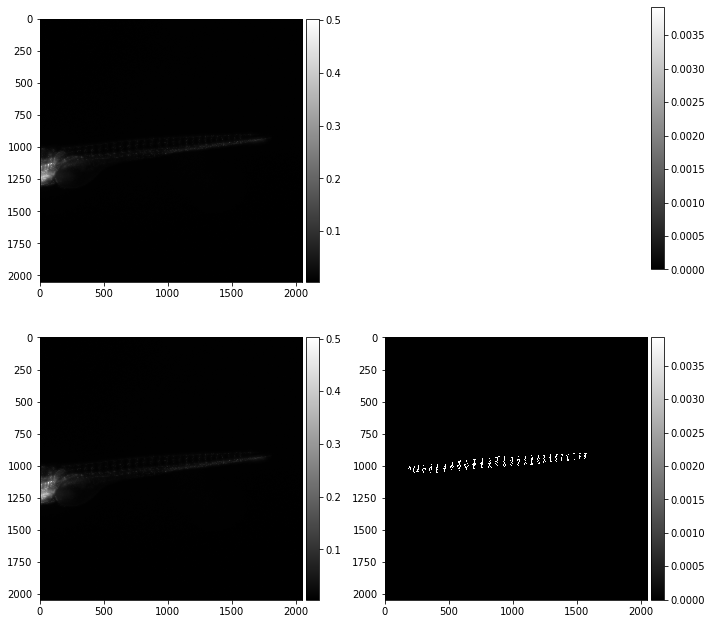

In [16]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(221)
imshow(train_data[1,:,:], cmap=plt.get_cmap('gray'))
plt.subplot(222)
imshow(train_labels[1, :, :], cmap=plt.get_cmap('gray'))
plt.subplot(223)
imshow(train_data[1, :, :], cmap=plt.get_cmap('gray'))
plt.subplot(224)
imshow(train_labels[1, :, :], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [67]:
#Each block of sehnet architecture consist of two Convolution layers
# These two layers are written in a function to make our code clean
def conv2d_block(input_tensor, n_filters, kernel_size=3,n_convnet=2, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if n_convnet>2:
        # second layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

In [68]:
# The u-net architecture consists of contracting and expansive paths which
# shrink and expands the inout image respectivly. 
# Output image have the same size of input image
def get_unet(input_img, n_filters, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*4, kernel_size=3) #The first block of U-net
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv2d_block(p1, n_filters=n_filters*8, kernel_size=3)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv2d_block(p2, n_filters=n_filters*16, kernel_size=3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv2d_block(p3, n_filters=n_filters*32, kernel_size=3)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*64, kernel_size=3)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*32, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters=n_filters*32, kernel_size=3)

    u7 = Conv2DTranspose(n_filters*16, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters=n_filters*16, kernel_size=3)

    u8 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters=n_filters*8, kernel_size=3)

    u9 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, n_filters=n_filters*4, kernel_size=3)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [69]:
def dice_coefficient(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + eps)

In [73]:
input_img = Input((train_data.shape[1], train_data.shape[2],1), name='img')
model = get_unet(input_img, n_filters=2, batchnorm=False)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[dice_coefficient])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 2048, 2048,  0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 2048, 2048, 8 80          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 2048, 2048, 8 32          conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation_54 (Activation)      (None, 2048, 2048, 8 0           batch_normalization_54[0][0]     
____________________________________________________________________________________________

In [16]:
# saving the log and show it by tensorboard
NAME='UNet_gpu'
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
%load_ext tensorboard

In [74]:
## early stoping and chekPoint
early_stop = EarlyStopping(monitor='val_loss', patience=50, mode='min')
filepath="weights_best_ISV_2xdata_nobatchcorr.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
plotlosses = PlotLossesKeras()
callbacks_list = [checkpoint, early_stop,plotlosses]

In [65]:
model = load_model("weights_best_ISV.hdf5", custom_objects={'dice_coefficient': dice_coefficient})

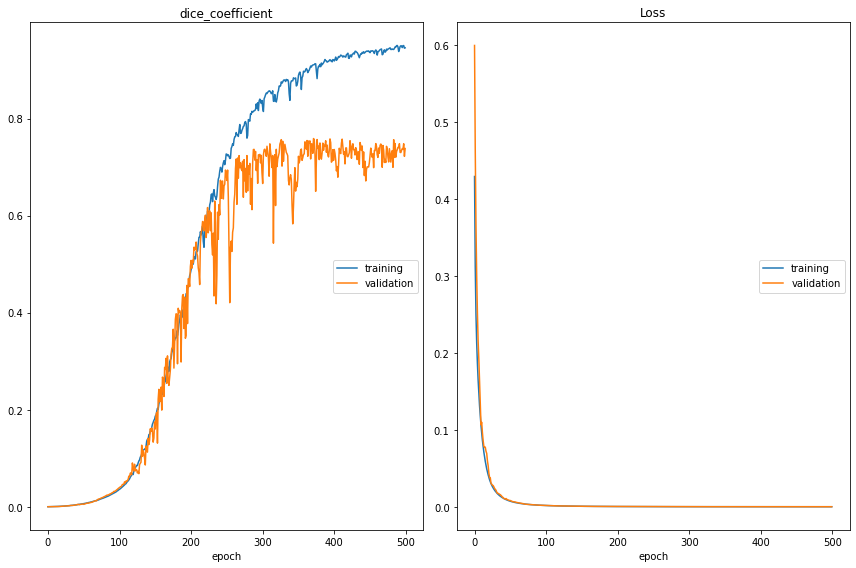

dice_coefficient
	training         	 (min:    0.000, max:    0.951, cur:    0.946)
	validation       	 (min:    0.000, max:    0.759, cur:    0.738)
Loss
	training         	 (min:    0.000, max:    0.429, cur:    0.000)
	validation       	 (min:    0.000, max:    0.599, cur:    0.000)


In [76]:
results = model.fit(train_data, train_labels, batch_size=3, epochs=500, callbacks=callbacks_list,
                    validation_split=0.3,verbose=2, shuffle=True)

In [28]:
model = load_model("weights_best_ISV.hdf5", custom_objects={'dice_coefficient': dice_coefficient})
#preds_test = model.predict(val_data, verbose=1)


In [38]:
def unseen_data_collect(path_train,final_size):
   
    listImages=os.listdir(path_train)[0:3]
    print(listImages)
    
    n_samples=len(listImages)
    X = np.zeros((n_samples, final_size, final_size), dtype=np.float32)
    #y = np.zeros((n_samples, final_size, final_size), dtype=np.float32)
    
    count=0
    for i in listImages:
        img=imread(path_train+"/"+i)
        image_downscaled=skimage.transform.resize(img, (final_size, final_size),anti_aliasing=False).astype(np.float32)


        #listMask=os.listdir(path_train)
        #mask=imread(path_train+"Annotations/CI/"+i)
        #msk=mask[:crop,:crop]
        #mask_downscaled=skimage.transform.resize(msk, (final_size, final_size),anti_aliasing=False).astype(np.float32)
        #print(image_downscaled.shape)
        #print(mask_downscaled.shape)
        X[count,:,:]=image_downscaled
        #y[count,:,:]=mask_downscaled

        count+=1
        print(count)
    return X

In [39]:
path_unseen="D:/AlexanderErnst/DeepLearning_ISV/Data/Max_projections"
X_unseen=unseen_data_collect(path_unseen,2048)

['MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A001.tif', 'MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A002.tif', 'MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A003.tif']
1
2
3


In [28]:
X_unseen.shape

(3, 2048, 2048)

In [40]:

preds_unseen = model.predict(X_unseen, verbose=1)
preds_unseen_t = (preds_unseen > 0.002).astype(np.uint8)

1/1 [==============================] - 3s 3s/step


NameError: name 'preds_unseen_t' is not defined

In [45]:
model = load_model("weights_best_ISV.hdf5", custom_objects={'dice_coefficient': dice_coefficient})
def model_predictions(path_images,path_save,final_size):
   
    listImages=os.listdir(path_images)
    print(listImages)
    
    n_samples=len(listImages)
    X = np.zeros((n_samples, final_size, final_size), dtype=np.float32)
    #y = np.zeros((n_samples, final_size, final_size), dtype=np.float32)
    
    count=0
    for i in listImages:
        img_arr=np.zeros((1, final_size, final_size), dtype=np.float32)
        img=imread(path_images+"/"+i)
        image_downscaled=skimage.transform.resize(img, (final_size, final_size),anti_aliasing=False).astype(np.float32)
        img_arr[0,:,:]=image_downscaled

        preds_unseen = model.predict(img_arr, verbose=1)
        preds_unseen_t = (preds_unseen > 0.002).astype(np.uint8)
        print(preds_unseen_t.shape)
        skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)
        
        
        

        count+=1
        print(count)
    return X
path_im="D:/AlexanderErnst/DeepLearning_ISV/Data/Max_projections"
path_sa="D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions"
f_size=2048
predictions=model_predictions(path_im,path_sa,f_size)

In [46]:
path_im="D:/AlexanderErnst/DeepLearning_ISV/Data/Max_projections"
path_sa="D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions"
f_size=2048
predictions=model_predictions(path_im,path_sa,f_size)

['MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A001.tif', 'MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A002.tif', 'MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A003.tif', 'MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A004.tif', 'MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A005.tif', 'MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A006.tif', 'MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A007.tif', 'MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A008.tif', 'MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A009.tif', 'MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A010.tif', 'MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A011.tif', 'MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A012.tif', 'MAX_201217153949_20201218_drugscreen__

<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A001.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 104ms/step
(1, 2048, 2048, 1)
2


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A002.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 100ms/step
(1, 2048, 2048, 1)
3


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A003.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 100ms/step
(1, 2048, 2048, 1)
4


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A004.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 109ms/step
(1, 2048, 2048, 1)
5


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A005.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 104ms/step
(1, 2048, 2048, 1)
6


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A006.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 100ms/step
(1, 2048, 2048, 1)
7


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A007.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 105ms/step
(1, 2048, 2048, 1)
8


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A008.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 103ms/step
(1, 2048, 2048, 1)
9


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A009.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 98ms/step
(1, 2048, 2048, 1)
10


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A010.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 111ms/step
(1, 2048, 2048, 1)
11


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A011.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 106ms/step
(1, 2048, 2048, 1)
12


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_A012.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 97ms/step
(1, 2048, 2048, 1)
13


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_B001.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 97ms/step
(1, 2048, 2048, 1)
14


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_B002.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 103ms/step
(1, 2048, 2048, 1)
15


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_B003.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 106ms/step
(1, 2048, 2048, 1)
16


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_B004.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 106ms/step
(1, 2048, 2048, 1)
17


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_B005.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 103ms/step
(1, 2048, 2048, 1)
18


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_B006.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 105ms/step
(1, 2048, 2048, 1)
19


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_B007.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 105ms/step
(1, 2048, 2048, 1)
20


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_B008.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 104ms/step
(1, 2048, 2048, 1)
21


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_B009.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 105ms/step
(1, 2048, 2048, 1)
22


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_B010.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 106ms/step
(1, 2048, 2048, 1)
23


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_B011.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 108ms/step
(1, 2048, 2048, 1)
24


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_B012.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 102ms/step
(1, 2048, 2048, 1)
25


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_C001.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 109ms/step
(1, 2048, 2048, 1)
26


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_C002.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 95ms/step
(1, 2048, 2048, 1)
27


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_C003.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 102ms/step
(1, 2048, 2048, 1)
28


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_C004.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 91ms/step
(1, 2048, 2048, 1)
29


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_C005.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 119ms/step
(1, 2048, 2048, 1)
30


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_C006.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 106ms/step
(1, 2048, 2048, 1)
31


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_C007.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 104ms/step
(1, 2048, 2048, 1)
32


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_C008.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 102ms/step
(1, 2048, 2048, 1)
33


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_C009.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 110ms/step
(1, 2048, 2048, 1)
34


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_C010.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 102ms/step
(1, 2048, 2048, 1)
35


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_C011.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 105ms/step
(1, 2048, 2048, 1)
36


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_C012.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 118ms/step
(1, 2048, 2048, 1)
37


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_D001.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 106ms/step
(1, 2048, 2048, 1)
38


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_D002.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 115ms/step
(1, 2048, 2048, 1)
39


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_D003.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 98ms/step
(1, 2048, 2048, 1)
40


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_D004.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 107ms/step
(1, 2048, 2048, 1)
41


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_D005.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 103ms/step
(1, 2048, 2048, 1)
42


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_D006.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 98ms/step
(1, 2048, 2048, 1)
43


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_D007.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 96ms/step
(1, 2048, 2048, 1)
44


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_D008.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 103ms/step
(1, 2048, 2048, 1)
45


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_D009.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 102ms/step
(1, 2048, 2048, 1)
46


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_D010.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 106ms/step
(1, 2048, 2048, 1)
47


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_D011.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 107ms/step
(1, 2048, 2048, 1)
48


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_D012.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 101ms/step
(1, 2048, 2048, 1)
49


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_E001.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 107ms/step
(1, 2048, 2048, 1)
50


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_E002.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 94ms/step
(1, 2048, 2048, 1)
51


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_E003.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 103ms/step
(1, 2048, 2048, 1)
52


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_E004.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 106ms/step
(1, 2048, 2048, 1)
53


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_E005.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 105ms/step
(1, 2048, 2048, 1)
54


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_E006.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 111ms/step
(1, 2048, 2048, 1)
55


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_E007.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 96ms/step
(1, 2048, 2048, 1)
56


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_E008.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 93ms/step
(1, 2048, 2048, 1)
57


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_E009.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 96ms/step
(1, 2048, 2048, 1)
58


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_E010.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 101ms/step
(1, 2048, 2048, 1)
59


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_E011.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 98ms/step
(1, 2048, 2048, 1)
60


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_E012.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 96ms/step
(1, 2048, 2048, 1)
61


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_F001.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 95ms/step
(1, 2048, 2048, 1)
62


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_F002.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 95ms/step
(1, 2048, 2048, 1)
63


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_F003.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 92ms/step
(1, 2048, 2048, 1)
64


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_F004.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 96ms/step
(1, 2048, 2048, 1)
65


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_F005.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 102ms/step
(1, 2048, 2048, 1)
66


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_F006.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 85ms/step
(1, 2048, 2048, 1)
67


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_F007.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 99ms/step
(1, 2048, 2048, 1)
68


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_F008.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 93ms/step
(1, 2048, 2048, 1)
69


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_F009.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 92ms/step
(1, 2048, 2048, 1)
70


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_F010.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 84ms/step
(1, 2048, 2048, 1)
71


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_F011.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 94ms/step
(1, 2048, 2048, 1)
72


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_F012.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 114ms/step
(1, 2048, 2048, 1)
73


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_G001.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 109ms/step
(1, 2048, 2048, 1)
74


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_G002.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 106ms/step
(1, 2048, 2048, 1)
75


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_G003.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 111ms/step
(1, 2048, 2048, 1)
76


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_G004.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 103ms/step
(1, 2048, 2048, 1)
77


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_G005.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 113ms/step
(1, 2048, 2048, 1)
78


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_G006.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 102ms/step
(1, 2048, 2048, 1)
79


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_G007.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 106ms/step
(1, 2048, 2048, 1)
80


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_G008.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 108ms/step
(1, 2048, 2048, 1)
81


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_G009.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 107ms/step
(1, 2048, 2048, 1)
82


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_G010.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 108ms/step
(1, 2048, 2048, 1)
83


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_G011.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 104ms/step
(1, 2048, 2048, 1)
84


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_G012.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 102ms/step
(1, 2048, 2048, 1)
85


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_H001.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 100ms/step
(1, 2048, 2048, 1)
86


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_H002.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 113ms/step
(1, 2048, 2048, 1)
87


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_H003.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 101ms/step
(1, 2048, 2048, 1)
88


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_H004.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 102ms/step
(1, 2048, 2048, 1)
89


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_H005.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 108ms/step
(1, 2048, 2048, 1)
90


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_H006.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 104ms/step
(1, 2048, 2048, 1)
91


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_H007.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 102ms/step
(1, 2048, 2048, 1)
92


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_H008.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 106ms/step
(1, 2048, 2048, 1)
93


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_H009.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 97ms/step
(1, 2048, 2048, 1)
94


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_H010.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 99ms/step
(1, 2048, 2048, 1)
95


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_H011.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


1/1 [==============================] - 0s 100ms/step
(1, 2048, 2048, 1)
96


<ipython-input-45-9b59231d7783>:20: UserWarning: D:/AlexanderErnst/DeepLearning_ISV/Data/Predictions/UNetSeg_MAX_201217153949_20201218_drugscreen__FliV_Myl7mR_D02_D11_4x_BF_470_H012.tif.tif is a low contrast image
  skimage.io.imsave(path_save+"/UNetSeg_"+i+".tif",preds_unseen_t)


In [19]:
preds_test = model.predict(val_data, verbose=1)

2/2 [==============================] - 4s 1s/step


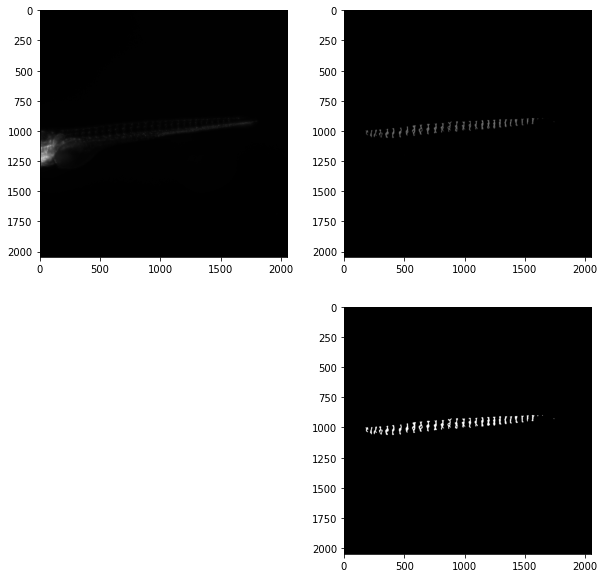

<ipython-input-42-b70f84152baa>:13: UserWarning: UNetSeg_.tif is a low contrast image
  skimage.io.imsave("UNetSeg_.tif",preds_unseen_t)


In [42]:
preds_unseen_t = (preds_unseen > 0.001).astype(np.uint8)
number=1
fig = plt.figure(figsize=(10, 10))
plt.subplot(221)

plt.imshow(X_unseen[number,:,:], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(preds_unseen[number, :, :], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(preds_unseen_t[number, :, :], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()
skimage.io.imsave("UNetSeg_.tif",preds_unseen_t)

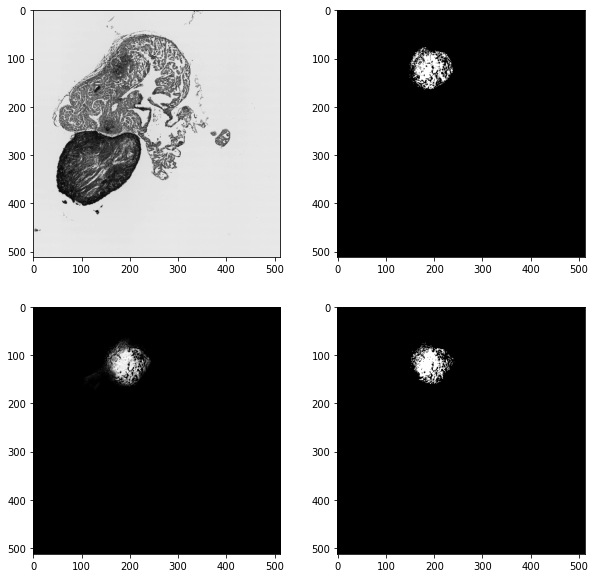

In [65]:
preds_test_t = (preds_test > 0.45).astype(np.uint8)
number=38
fig = plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(val_data[number,:,:], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(val_labels[number, :, :], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(preds_test[number, :, :], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(preds_test_t[number, :, :], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

# Neuer Abschnitt